# Healthcare Graphs Analysis
This Jupyter Notebook retrieves, processes, and visualises life expectancy and healthcare costs over the years in Singapore using data from:
- [**Life Expectancy dataset**](https://tablebuilder.singstat.gov.sg/table/TS/M810501#!)
- [**CPI dataset**](https://data.gov.sg/datasets/d_de7e93a1d0e22c790516a632747bf7f0/view?dataExplorerPage=9)
## Libraries

In [224]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt

# Constants for API endpoints
BASE_DATA_GOV_URL = "https://data.gov.sg/api/action/datastore_search"
BASE_SINGSTAT_URL = "https://tablebuilder.singstat.gov.sg/api/table/tabledata"

## Data Retrieval Functions 

In [225]:
# function to fetch data from data.gov.sg 
def fetch_datagov_dataset(dataset_id: str, limit: int=10_000_000) -> pd.DataFrame:
    """
    Fetch dataset from data.gov.sg API.

    Args: 
        dataset_id (str): The dataset ID from data.gov.sg.
        limit (int, optional): Number of records to fetch. Defaults to 10 million.

    Returns: 
        pd.DataFrame: Data retrieved in DataFrame format.
    """
    response = requests.get(BASE_DATA_GOV_URL, params={"resource_id": dataset_id, "limit": limit})
    data = response.json()
    
    if not data["success"]:
        raise Error(f"Failed to fetch dataset ({dataset_id}).")
        
    return pd.DataFrame(data["result"]["records"])

In [226]:
def parse_singstat_2d_data(raw_data: dict) -> pd.DataFrame:
    """
    Parse the JSON data from SingStat API into a structured DataFrame.

    Args: 
        raw_data (dict): Raw JSON data from SingState API.

    Returns: 
        pd.DataFrame: Parsed DataFrame with years as columns.
    """
    rows = raw_data.get("Data", {}).get("row", [])
    records = []

    for row in rows:
        series_name = row.get("rowText", "")
        columns = row.get("columns", [])
        series_data = {col["key"]: col["value"] for col in columns}
        series_data["Series"] = series_name
        records.append(series_data)

    df = pd.DataFrame(records)
    df.set_index("Series")
    df.columns.name = "Year"
    return df

def fetch_singstat_dataset(dataset_id: str, limit: int = 10_000_000) -> pd.DataFrame:
    """ 
    Fetch dataset from SingStat API.

    Args: 
        dataset_id (str): The dataset ID from SingStat.
        limit (int, optional): Number of records to fetch. Defaults to 10 million.

    Returns:
        pd.DataFrame: Data retrieved in DataFrame format.
    """
    response = requests.get(
        f"{BASE_SINGSTAT_URL}/{dataset_id}",
        params={"limit": limit},
        headers={
            "Accept": "application/json",
            "User-Agent": "curl/8.11.1", # Need to fake the user agent because SingStat blocks `python-requests`.
        }
    )
    data = response.json()
    return parse_singstat_2d_data(data)

## Fetch Data

In [227]:
# Fetch Consumer Price Index (CPI) dataset from data.gov.sg
datagov_dataset_id = "d_de7e93a1d0e22c790516a632747bf7f0"
cpi_df = fetch_datagov_dataset(datagov_dataset_id)

# Fetch Life Expectancy dataset from SingStat
sing_stat_dataset_id = "M810501"
lx_df = fetch_singstat_dataset(sing_stat_dataset_id)

## Data Exploration 

In [228]:
cpi_df.head()

,_id,DataSeries,2024Dec,2024Nov,2024Oct,2024Sep,2024Aug,2024Jul,2024Jun,2024May,...,1961Oct,1961Sep,1961Aug,1961Jul,1961Jun,1961May,1961Apr,1961Mar,1961Feb,1961Jan
0,1,All Items,117.197,116.792,116.756,117.123,116.829,116.028,116.323,116.574,...,24.463,24.393,24.517,24.276,24.223,24.053,24.187,24.585,24.565,24.542
1,2,Food,119.272,118.981,118.897,118.693,118.553,118.368,118.361,118.332,...,21.614,21.506,21.699,21.323,21.242,20.967,21.172,21.82,21.777,21.762
2,3,Food Excl Food Serving Services,118.209,117.746,117.707,117.649,117.03,116.54,116.641,116.975,...,na,na,na,na,na,na,na,na,na,na
3,4,Bread & Cereals,119.91,119.717,119.428,118.818,118.12,118.209,117.849,117.711,...,na,na,na,na,na,na,na,na,na,na
4,5,Rice,105.233,104.995,104.408,105.534,103.426,104.208,103.349,104.059,...,na,na,na,na,na,na,na,na,na,na


In [229]:
lx_df.head()

Year,1957,1960,1965,1970,1975,1980,1981,1982,1983,1984,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Series
0,61.1,62.9,64.5,65.8,66.8,72.1,72.5,72.6,73,73.3,...,82.9,83,83.2,83.4,83.7,83.7,83.2,83,83,Total Life Expectancy At Birth (Residents)
1,59.4,61.2,62.8,64.1,65.1,69.8,70.1,70.2,70.5,70.9,...,80.5,80.7,80.9,81.2,81.4,81.3,80.8,80.7,80.7,Male Life Expectancy At Birth (Residents)
2,63.2,65,66.6,67.8,68.8,74.7,75.2,75.3,75.7,75.8,...,85.1,85.1,85.4,85.5,85.9,85.9,85.5,85.2,85.2,Female Life Expectancy At Birth (Residents)
3,8.1,8.3,8.3,8.4,8.5,14,14.2,14.2,14.4,14.6,...,20.8,20.8,21,21.2,21.4,21.3,20.9,20.7,20.7,Total Life Expectancy At Age 65 Years (Residents)
4,7.5,7.8,7.8,8,8.2,12.6,12.7,12.8,13,13.2,...,18.9,19,19.2,19.4,19.5,19.5,19.1,19,19,Male Life Expectancy At Age 65 Years (Residents)


### Check summary statistc for dataframe

In [230]:
cpi_df.describe()

,_id
count,152.000000
mean,76.500000
std,44.022721
min,1.000000
25%,38.750000
50%,76.500000
75%,114.250000
max,152.000000


In [231]:
lx_df.describe()

Year,1957,1960,1965,1970,1975,1980,1981,1982,1983,1984,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Series
count,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
unique,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
top,61.1,62.9,64.5,65.8,66.8,72.1,72.5,72.6,73,73.3,...,82.9,83,83.2,83.4,83.7,83.7,83.2,83,83,Total Life Expectancy At Birth (Residents)
freq,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


#### Check for null data

In [232]:
cpi_df.isnull().sum()

_id           0
DataSeries    0
2024Dec       0
2024Nov       0
2024Oct       0
             ..
1961May       0
1961Apr       0
1961Mar       0
1961Feb       0
1961Jan       0
Length: 770, dtype: int64

In [233]:
lx_df.isnull().sum()

Year
1957      0
1960      0
1965      0
1970      0
1975      0
1980      0
1981      0
1982      0
1983      0
1984      0
1985      0
1986      0
1987      0
1988      0
1989      0
1990      0
1991      0
1992      0
1993      0
1994      0
1995      0
1996      0
1997      0
1998      0
1999      0
2000      0
2001      0
2002      0
2003      0
2004      0
2005      0
2006      0
2007      0
2008      0
2009      0
2010      0
2011      0
2012      0
2013      0
2014      0
2015      0
2016      0
2017      0
2018      0
2019      0
2020      0
2021      0
2022      0
2023      0
Series    0
dtype: int64

#### View data types

In [234]:
cpi_df.dtypes

_id            int64
DataSeries    object
2024Dec       object
2024Nov       object
2024Oct       object
               ...  
1961May       object
1961Apr       object
1961Mar       object
1961Feb       object
1961Jan       object
Length: 770, dtype: object

In [235]:
lx_df.dtypes

Year
1957      object
1960      object
1965      object
1970      object
1975      object
1980      object
1981      object
1982      object
1983      object
1984      object
1985      object
1986      object
1987      object
1988      object
1989      object
1990      object
1991      object
1992      object
1993      object
1994      object
1995      object
1996      object
1997      object
1998      object
1999      object
2000      object
2001      object
2002      object
2003      object
2004      object
2005      object
2006      object
2007      object
2008      object
2009      object
2010      object
2011      object
2012      object
2013      object
2014      object
2015      object
2016      object
2017      object
2018      object
2019      object
2020      object
2021      object
2022      object
2023      object
Series    object
dtype: object

## Data Cleaning

In [236]:
def get_yearly_avg(cpi_df: pd.DataFrame, y_range: int = 11) -> pd.DataFrame:
    """
    Calculate yearly average healthcare costs from monthly CPI data.

    Args:
        cpi_df (pd.DataFrame): CPI dataset.
        y_range (int, optional): Number of years to consider. Defaults to 11.

    Returns: 
        pd.DataFrame: Yearly average healthcare cost.
    """
    current_year = 2023
    year_range = [str(current_year-x) for x in range(y_range)]

    yearly_avg = {}
    for year in year_range:
        month_col = [col for col in cpi_df.columns if col.startswith(year)]

        if month_col: 
            cpi_df[month_col] = cpi_df[month_col].apply(pd.to_numeric)
            yearly_avg[year] = cpi_df[month_col].sum(axis=1) / len(month_col)
            
    return pd.DataFrame(yearly_avg)


In [237]:
def format_life_expectancy(lx_df: pd.DataFrame, series_name: str ,y_range: int=11) -> pd.DataFrame:
    """
    Format and filter Life Expectancy dataset.

    Args:
        lx_df (pd.DataFrame): Life Expectancy dataset.
        series_name (str): The series name to extract. 
        y_range (int, optional): Number of years to soncider. Default to 11.

    Returns: 
        pd.DataFrame: Filtered and formatted DataFrame.
    """
    formated_df = lx_df[lx_df["Series"] == series_name].drop(columns=["Series"])
    years_to_use = [str(2023-x) for x in range(y_range)]

    return formated_df[years_to_use]

## Data Processing

In [244]:
# Filter CPI dataset to retain only healthcare data
cpi_df = cpi_df[cpi_df['DataSeries'].str.contains("Health Care")].reset_index(drop=True)

# Calculate yearly healthcare cost average
hc_yearly_df = get_yearly_avg(cpi_df, y_range=22)

In [239]:
# Format life expectancy data
series_name = "Total Life Expectancy At Birth (Residents)"
lx_yearly_df = format_life_expectancy(lx_df, series_name, y_range=22)

In [240]:
# Clean and merge both datasets
lx_yearly_df = lx_yearly_df.reset_index(drop=True)
merged_df = pd.concat([lx_yearly_df, hc_yearly_df])
merged_df.index = ["Life Expectancy", "Healthcare Average"]

In [241]:
# Transpose and format for visualisation 
merged_df = merged_df.T.reset_index().rename(columns={"index": "Year"})
merged_df["Year"] = merged_df["Year"].astype(int)

## Visualisation

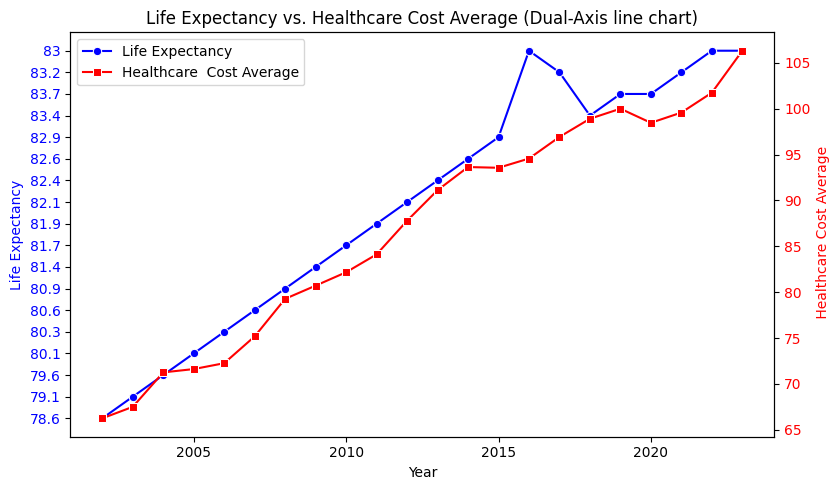

In [242]:
# Dual-axis line chart
fig, ax1 = plt.subplots(figsize=(10, 5))

# First Line: Life Expectancy 
sns.lineplot(data=merged_df, x="Year", y="Life Expectancy", marker="o", ax=ax1, color="blue", label="Life Expectancy", legend=False)  
ax1.set_ylabel("Life Expectancy", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Second Line: Healthcare Cost Average
ax2 = ax1.twinx()
sns.lineplot(data=merged_df, x="Year", y="Healthcare Average", marker='s', ax=ax2, color="red", label="Healthcare  Cost Average", legend=False)
ax2.set_ylabel(" Healthcare Cost Average", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# Legend & Labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=0)

# Title and Layout 
ax1.set_xlabel("Year")
ax1.set_title("Life Expectancy vs. Healthcare Cost Average (Dual-Axis line chart)")
fig.tight_layout(rect=[0, 0, 0.85, 1])

# Show plot
plt.show()